# Given problem could be solved by using hasmaps with run time of O(n) and memory usage of O(n) in worst case senarios because it's possible to write a deterministic function to compute hasmap of parent of leaf nodes.

# Below we will try to solve it with machine learning.

In [36]:
import matplotlib
import os
import numpy as np
import pandas as pd
import json
import io
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
from __future__ import print_function
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit

from collections import defaultdict


%matplotlib inline  

# GUI twiks

In [22]:
pd.set_option('display.max_colwidth', -1)
pd.set_option("display.max_rows",999)


#pd.reset_option("display.max_rows")
#pd.get_option("display.max_rows")

# Loading data into dataframe and calculating depth of the leaf nodes.

In [23]:
d = defaultdict(LabelEncoder)

category_json_path = 'categories.json'
cat_file = open(category_json_path).read()
cat_js = json.loads(cat_file)
cat_dict_by_id = {}

for x in cat_js:
    cat_dict_by_id[x['id']] = x
    
all_leaf_list = []
for x in list(filter(lambda x: x['leaf'] == True, cat_js)):
    all_leaf_list.append(x)
    
df = pd.read_json(cat_file)
df['depth'] = None
df.loc[:,['depth']] = (df.apply(lambda row: float(len(row['path'].split('>'))), axis=1)).values

# A sneak peek of our dataset.

In [24]:
df.head(10)

,id,leaf,name,path,pathWithIds,depth
0,10161,False,Computers & Accessories,Computers & Accessories,10161,1.0
1,10162,False,Sports & Outdoors,Sports & Outdoors,10162,1.0
2,10163,False,Automotive,Automotive,10163,1.0
3,10164,False,Home & Kitchen,Home & Kitchen,10164,1.0
4,10165,False,Office Products,Office Products,10165,1.0
5,10166,False,Clothing & Accessories,Clothing & Accessories,10166,1.0
6,10167,False,Tools & Home Improvement,Tools & Home Improvement,10167,1.0
7,10168,False,Electronics,Electronics,10168,1.0
8,10169,False,Jewelry,Jewelry,10169,1.0
9,10170,False,Health & Personal Care,Health & Personal Care,10170,1.0


# Sample of our interest containing leaf nodes only.

In [25]:
df[df.leaf == True].head(10)

,id,leaf,name,path,pathWithIds,depth
24,15999,True,Internal Cd Drives,Computers & Accessories > Computer Components > Internal Optical Drives > Internal Cd Drives,10161 > 15997 > 15998 > 15999,4.0
29,16004,True,Boys,Sports & Outdoors > Fan Shop > Clothing & Accessories > Sweatshirts > Kids > Boys,10162 > 16000 > 16001 > 16002 > 16003 > 16004,6.0
33,16008,True,Boots,Automotive > Motorcycle & Powersports > Protective Gear > Footwear > Boots,10163 > 16005 > 16006 > 16007 > 16008,5.0
35,16010,True,Kids Bikes & Accessories,Sports & Outdoors > Cycling > Kids Bikes & Accessories,10162 > 16009 > 16010,3.0
38,16013,True,Bells & Sleigh Bells,Home & Kitchen > Seasonal Décor > Ornaments > Bells & Sleigh Bells,10164 > 16011 > 16012 > 16013,4.0
42,16017,True,Link Kits,Automotive > Replacement Parts > Shocks Struts & Suspension > Sway Bars & Parts > Link Kits,10163 > 16014 > 16015 > 16016 > 16017,5.0
45,16020,True,Foam Boards,Office Products > Education & Crafts > Arts & Crafts Supplies > Foam Boards,10165 > 16018 > 16019 > 16020,4.0
49,16023,True,Tankinis,Clothing & Accessories > Women > Swimsuits & Cover Ups > Tankinis,10166 > 16021 > 16022 > 16023,4.0
51,16026,True,Wear To Work,Clothing & Accessories > Women > Maternity > Dresses > Wear To Work,10166 > 16021 > 16024 > 16025 > 16026,5.0
55,16030,True,Ceramic Tiles,Tools & Home Improvement > Building Supplies > Building Materials > Tiles > Ceramic Tiles,10167 > 16027 > 16028 > 16029 > 16030,5.0


# Further data pre-processing.


1. Converting all text to lower case.
2. Grouping on name to figure-out duplicate leafs.
3. Encoding data.
4. Building more features using one hot vectors (to compare performance of classifiers with synthetic features set).

In [26]:
df['name'] = df['name'].str.lower()
df['path'] = df['path'].str.lower()
names_count_df = df.groupby(['name']).agg(['count'])
names_duplicate_df = names_count_df[(names_count_df['id']['count'] > 1)]
df['duplicates'] = False
df['duplicates'] = np.where(df['name'].isin(names_duplicate_df.index) & df['leaf'] == True, 1, 0)

df = df[df.leaf == 1]

unique_categories = set()
#all_paths = [x.split('>') for x in df['path']]
#tmp = [unique_categories.update(each) for each in all_paths]

for c in unique_categories:
    df[c] = np.where(df['path'].str.contains(c), 1.0, 0.0)
    
    
df['leaf'] = np.where(df['leaf'] == True, 1.0, 0.0)

leName = LabelEncoder()
lePath = LabelEncoder()

leName.fit(df['name'])
df['name'] = leName.transform(df['name'])

lePath.fit(df['path'])
df['path'] = lePath.transform(df['path'])

# Data view after encoding.

In [27]:
df.head(5)

,id,leaf,name,path,pathWithIds,depth,duplicates
24,15999,1.0,2526,1796,10161 > 15997 > 15998 > 15999,4.0,0
29,16004,1.0,604,6034,10162 > 16000 > 16001 > 16002 > 16003 > 16004,6.0,1
33,16008,1.0,575,414,10163 > 16005 > 16006 > 16007 > 16008,5.0,1
35,16010,1.0,2625,5843,10162 > 16009 > 16010,3.0,0
38,16013,1.0,429,3782,10164 > 16011 > 16012 > 16013,4.0,0


In [28]:
display(HTML('<h1>Duplicate percentage in prepared dataset: <span style="background-color: yellow;">'+str((float(len(df[df.duplicates == 1]))/float(len(df)))*100)+ ' %.</span></h1>'))

# As we can see above we have almost uniform distribution of duplicate leafs in our filtered dataset, so we can use Accuracy matric for evaluation of our classifiers instead of using F-score, Precision, Recall etc..

<span style="background-color: #fdffa3; font-size: 20px;">Below is a **historgram** graph showing distribution of duplicate and single leafs in our filtered dataset.</span>

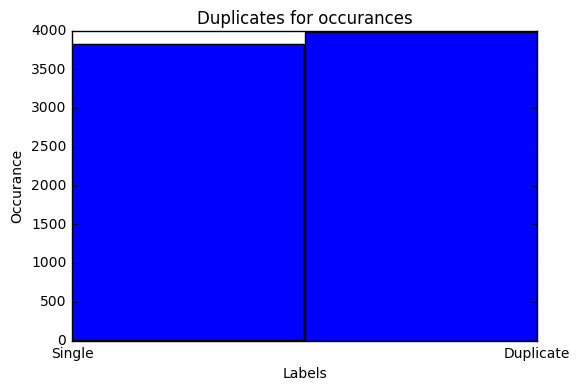

In [30]:
plt.hist(df.duplicates,bins = [0.0,0.5,1.0])
plt.ylabel('Occurance')
plt.xlabel('Labels')
frame = plt.gca()
frame.axes.get_xaxis().set_ticks([0,1])
plt.xticks(df.duplicates,['Single','Duplicate'])
plt.title('Duplicates for occurances')
plt.show()

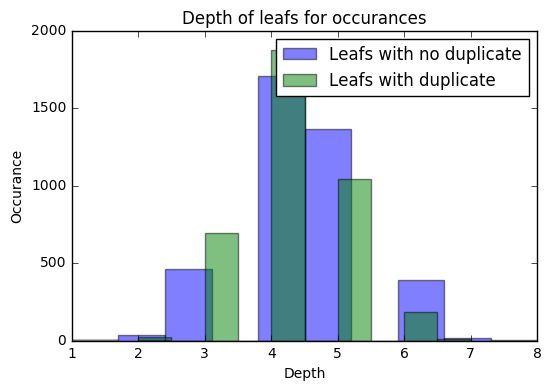

In [31]:
#plt.hist(df.depth)
plt.ylabel('Occurance')
plt.xlabel('Depth')
plt.hist(df.depth[df.duplicates == 1], alpha=0.5, label='Leafs with no duplicate')
plt.hist(df.depth[df.duplicates == 0], alpha=0.5, label='Leafs with duplicate')
plt.legend(loc='upper right')
plt.title('Depth of leafs for occurances')
plt.show()

In [32]:
df_with_encode = df.copy()

df_with_encode.drop('path', axis=1, inplace=True)
df_with_encode.drop('id', axis=1, inplace=True)
df_with_encode.drop('pathWithIds', axis=1, inplace=True)

x_with_encode = df_with_encode.copy()
y_with_encode = df_with_encode['duplicates']
x_with_encode.drop('duplicates', axis=1, inplace=True)

In [33]:
x = df.copy()

x.drop('id', axis=1, inplace=True)
x.drop('pathWithIds', axis=1, inplace=True)

y = df['duplicates']
x.drop('duplicates', axis=1, inplace=True)

In [7]:
def classify(clf):
    print("--------------------------------\nTraining with: "+str(clf))
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    clf_descr = str(clf).split('(')[0]
    return str(clf), clf_descr, score

def classify_with_encode(clf):
    print("--------------------------------\nTraining with -- with_encode : "+str(clf))
    clf.fit(X_train_with_encode, y_train_with_encode)
    pred = clf.predict(X_test_with_encode)
    score = metrics.accuracy_score(y_test_with_encode, pred)
    print("accuracy:   %0.3f" % score)
    clf_descr = str(clf).split('(')[0]
    return str(clf)+"___with_encode", clf_descr, score

In [34]:
X_train_with_encode, X_test_with_encode, y_train_with_encode, y_test_with_encode = train_test_split(x_with_encode, y_with_encode, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [35]:
def classify(clf):
    print("--------------------------------\nTraining with: "+str(clf))
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    clf_descr = str(clf).split('(')[0]
    return str(clf), clf_descr, score

def classify_with_encode(clf):
    print("--------------------------------\nTraining with -- with_encode : "+str(clf))
    clf.fit(X_train_with_encode, y_train_with_encode)
    pred = clf.predict(X_test_with_encode)
    score = metrics.accuracy_score(y_test_with_encode, pred)
    print("accuracy:   %0.3f" % score)
    clf_descr = str(clf).split('(')[0]
    return str(clf)+"___with_encode", clf_descr, score

# Quick performance review for different classifiers on our dataset.

In [8]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        #(Perceptron(n_iter=50), "Perceptron"),
        #(PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest"),
        (AdaBoostClassifier(),"AdaBoost Classifier")):
    results.append(classify(clf))
    results.append(classify_with_encode(clf))

--------------------------------
Training with: RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
accuracy:   0.508
--------------------------------
Training with -- with_encode : RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
accuracy:   0.491
--------------------------------
Training with: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')
accuracy:   0.639
--------------------------------
Training with -- with_encode : KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')
accuracy:   0.638
--------------------------------

# Further trying to optimize the RandomForestClassifier selected from above evaluation using GridSearchCV

**Note: ** We can also use __RandomizedSearchCV__ for performance improvements.

In [9]:
def scoring_a(y_true, y_predict):
    return metrics.accuracy_score(y_true, y_predict)

Excluding "oob_score" as it will through error with "bootstrap = False"

**_Note:_**: Below code was executed on AWS GUP enabled (g2.2xlarge) instance to gain more CPU power.

In [11]:
clf = RandomForestClassifier()
parameters = {
                'n_estimators':(70,80,90,100,110,120,130),
                'warm_start':(True, False),
                'criterion':('gini','entropy'), 
                #'oob_score':(True, False),
                'bootstrap':(True,False),
                'min_samples_split':(1,2,3),
                'random_state':[4242]
            }
scorer = make_scorer(scoring_a)
cv_sets = ShuffleSplit(X_train.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)
grid_obj = GridSearchCV(clf, parameters, cv = cv_sets)#, scoring = scorer)
grid_fit = grid_obj.fit(X_train, y_train)
best_clf = grid_fit.best_estimator_
print("Best Accuracy: "+str(scoring_a(best_clf.predict(X_test),y_test)))
print(best_clf)

Best Accuracy: 0.705516705517
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
            oob_score=False, random_state=4242, verbose=0, warm_start=True)


**Trying best parameters obtained by above GridSearchCV with oob_score = True to see if we can improve model's performance further.**

In [20]:
clf = RandomForestClassifier()
parameters = {
                'n_estimators':[70],
                'warm_start':[True, False],
                'criterion':['entropy','gini'], 
                'oob_score':[True, False],
                'bootstrap':[True],
                'min_samples_split':[1],
                'random_state':[4242]
            }
scorer = make_scorer(scoring_a)
cv_sets = ShuffleSplit(X_train.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)
grid_obj = GridSearchCV(clf, parameters, cv = cv_sets)#, scoring = scorer)
grid_fit = grid_obj.fit(X_train, y_train)
best_clf = grid_fit.best_estimator_
print("Best Accuracy: "+str(scoring_a(best_clf.predict(X_test),y_test)))
print(best_clf)

Best Accuracy: 0.705516705517
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
            oob_score=True, random_state=4242, verbose=0, warm_start=True)


# _Conclusion_: RandomForestClassifier gave us best results (70%) with default settings further optimization using GridSearchCV did't produce significant improvements in model's performance.